# ABM SA (sensitivity analysis)

This notebook containts the following tests for the ABM sensitivity analyses:
1. Number of streets to patrol (SA_hotStreets.py). Range: 2, 5, 10. For 4 agents per precinct (targetted deployement to hottest beats) and the SA_set of 100 shifts randomly chosen throughout 2018.

In [1]:
import os
print(os.getcwd())

import osmnx as ox
import pandas as pd

from datetime import datetime, timedelta, time
import datetime
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib as mpl
import pickle

import random

import warnings


/Users/natachachenevoy/Documents/GitHub/ABM-Detroit-Police-Dispatch/Validation


## 1 - Select 100 random (from 2018) shifts for SA_set

In [2]:
data = pd.read_csv("../Data/Incidents_new_preprocessed.csv")
data.Date_Time = pd.to_datetime(data.Date_Time)
data.Date_Time = data.Date_Time.dt.tz_localize(None)
#cfs_incidents['Patrol_beat'] = cfs_incidents['Patrol_beat'].apply(str)
#cfs_incidents['Precinct'] = cfs_incidents['Precinct'].apply(str)

# SELECT 2018 for validation (so that 2017 can be used for historical crimes)
data = data[(data['Date_Time'].dt.year == 2018)]


In [3]:
dates_uniques = data['Date_Time'].sort_values().dt.date.unique()
# Remove first and last date for full days.
#dates_uniques_weekdays = dates_uniques_weekdays[1:-2]
print('There are {} unique dates in dataset'.format(len(dates_uniques)))

There are 365 unique dates in dataset


In [4]:
# DF of shifts start and end times (plus duration)
shifts = pd.DataFrame({'start':[0, 8, 16], 'end':[8,16,24], 
                      'duration': [8,8,8]})
shifts

,start,end,duration
0,0,8,8
1,8,16,8
2,16,24,8


In [24]:
def get_3_shifts_for_date(date, df_shifts) :

    # Add new column with start date
    df_shifts = df_shifts.assign(date_start = np.repeat(date, 3))

    return df_shifts


list_of_dfs = [get_3_shifts_for_date(date, shifts) for date in dates_uniques]  
df_shifts = pd.concat(list_of_dfs, ignore_index=True)
df_shifts

,start,end,duration,date_start
0,0,8,8,2018-01-01
1,8,16,8,2018-01-01
2,16,24,8,2018-01-01
3,0,8,8,2018-01-02
4,8,16,8,2018-01-02
...,...,...,...,...
1090,8,16,8,2018-12-30
1091,16,24,8,2018-12-30
1092,0,8,8,2018-12-31
1093,8,16,8,2018-12-31


In [25]:
def get_start_end_shift(row):
    start_date = row['date_start']
    start_time = datetime.time(row['start'],0)
    
    duration_hours = int(row['duration'])


    SHIFT_START_DT = datetime.datetime.combine(start_date, start_time)
    SHIFT_END_DT = SHIFT_START_DT + timedelta(hours = duration_hours)
    END_TIME = SHIFT_END_DT.time()

    #print('Shift is from {} to {}'.format(SHIFT_START_DT,SHIFT_END_DT))
    #print('duration: {} hours'.format(SHIFT_END_DT - SHIFT_START_DT))
    return SHIFT_START_DT, SHIFT_END_DT



list_all_shifts = df_shifts.apply(get_start_end_shift, axis = 1)
list_all_shifts[0:5]



0    (2018-01-01 00:00:00, 2018-01-01 08:00:00)
1    (2018-01-01 08:00:00, 2018-01-01 16:00:00)
2    (2018-01-01 16:00:00, 2018-01-02 00:00:00)
3    (2018-01-02 00:00:00, 2018-01-02 08:00:00)
4    (2018-01-02 08:00:00, 2018-01-02 16:00:00)
dtype: object

In [28]:
np.random.seed(22)
# Sample without replacement
SA_set = np.random.choice(pd.Series([pair for pair in list_all_shifts if pair[0].year == 2018]), 100, replace = False)

print('SA_set:', len(set(SA_set)))



SA_set: 100


## SAVE FILES

In [29]:
import pickle
with open('./SA_set.pkl', 'wb') as f:
    pickle.dump(SA_set, f)


In [30]:
with open('SA_set.pkl', 'rb') as f:
    shifts = pickle.load(f)
shifts

array([(datetime.datetime(2018, 2, 27, 0, 0), datetime.datetime(2018, 2, 27, 8, 0)),
       (datetime.datetime(2018, 2, 3, 8, 0), datetime.datetime(2018, 2, 3, 16, 0)),
       (datetime.datetime(2018, 4, 14, 8, 0), datetime.datetime(2018, 4, 14, 16, 0)),
       (datetime.datetime(2018, 8, 30, 16, 0), datetime.datetime(2018, 8, 31, 0, 0)),
       (datetime.datetime(2018, 1, 28, 8, 0), datetime.datetime(2018, 1, 28, 16, 0)),
       (datetime.datetime(2018, 7, 30, 16, 0), datetime.datetime(2018, 7, 31, 0, 0)),
       (datetime.datetime(2018, 6, 30, 0, 0), datetime.datetime(2018, 6, 30, 8, 0)),
       (datetime.datetime(2018, 3, 31, 16, 0), datetime.datetime(2018, 4, 1, 0, 0)),
       (datetime.datetime(2018, 9, 17, 8, 0), datetime.datetime(2018, 9, 17, 16, 0)),
       (datetime.datetime(2018, 12, 28, 0, 0), datetime.datetime(2018, 12, 28, 8, 0)),
       (datetime.datetime(2018, 1, 2, 16, 0), datetime.datetime(2018, 1, 3, 0, 0)),
       (datetime.datetime(2018, 11, 6, 0, 0), datetime.datet

## 2 - Run SA on HPC 

## 3 - Interprete results here

### 1. Number of hot streets

In [5]:
with open('dict_SA_hotStreets.pkl', 'rb') as f:
        dict_num_hot_streets = pickle.load(f)
dict_num_hot_streets

{2: [3296,
  3222,
  3162,
  1499,
  4080,
  1205,
  4192,
  922,
  2725,
  4637,
  2500,
  2553,
  3084,
  3811,
  1351,
  860,
  3245,
  1907,
  2955,
  6841,
  7731,
  4814,
  7266,
  3754,
  3668,
  1302,
  3330,
  3750,
  3176,
  3986,
  3924,
  4079,
  5876,
  7068,
  1808,
  2049,
  3659,
  7716,
  4125,
  3204,
  788,
  1182,
  1204,
  1479,
  867,
  714,
  3543,
  1325,
  4891,
  1544,
  6644,
  1866,
  3281,
  913,
  3572,
  1307,
  1205,
  3424,
  5851,
  1955,
  6989,
  1978,
  4055,
  1299,
  7933,
  3182,
  4004,
  1019,
  3120,
  4466,
  5001,
  1237,
  998,
  910,
  2755,
  3676,
  3910,
  3708,
  7691,
  1002,
  3279,
  3747,
  7482,
  5787,
  902,
  4026,
  2586,
  1012,
  4796,
  1327,
  3694,
  3253,
  3070,
  3109,
  2764,
  3025,
  1561,
  1184,
  3298,
  7682],
 5: [3527,
  3134,
  2913,
  1434,
  3838,
  1180,
  3803,
  939,
  2626,
  5165,
  2572,
  2930,
  3283,
  3830,
  1328,
  989,
  2977,
  2192,
  2988,
  7243,
  6880,
  5054,
  7585,
  3666,
  3547,
  13

In [6]:
df = pd.DataFrame.from_dict(dict_num_hot_streets)
df

,2,5,10
0,3296,3527,3791
1,3222,3134,3680
2,3162,2913,3329
3,1499,1434,1419
4,4080,3838,4179
...,...,...,...
95,3025,3150,3306
96,1561,1499,1626
97,1184,1048,1135
98,3298,3243,3477


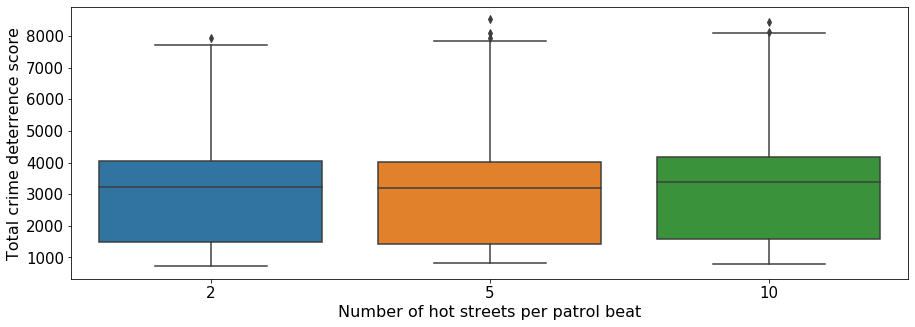

In [9]:
f, ax = plt.subplots(1, figsize=(15, 5))
sns.boxplot( data=df, ax = ax)


#f.suptitle('Total crime deterrence score for 2, 5 and 10 streets to patrol per beat', fontsize=20)


ax.set_xticklabels(ax.get_xticklabels(),rotation=0,  fontsize=15)




ax.set_ylabel('Total crime deterrence score', fontsize = 16)

ax.set_xlabel('Number of hot streets per patrol beat', fontsize = 16)
    
    
    
ax.tick_params(axis='y', labelsize=15)

#ax.set_title('Total crime deterrence score for 2, 5 and 10 streets to patrol per beat', fontsize = 16)

#ax1.set_ylim(0,50)

plt.savefig('../Images/SA_hotStreets.png', bbox_inches = 'tight')




plt.show()

In [38]:
num_agents = 4

In [59]:
"""filter_col = ['Real_dispatch_time', "Dispatch_time_{}".format(num_agents)]
df3 = df2[filter_col]
df3.columns = ['Observed', 'Generated']
df3.Generated.describe()"""

'filter_col = [\'Real_dispatch_time\', "Dispatch_time_{}".format(num_agents)]\ndf3 = df2[filter_col]\ndf3.columns = [\'Observed\', \'Generated\']\ndf3.Generated.describe()'

## Time saving (for dispatcher's redispatching on the fly)

In [97]:
with open('dict_pair_SA_timeSaving.pkl', 'rb') as f:
        dict_time_saving_percent= pickle.load(f)
#dict_time_saving_percent

In [78]:
dict_time_saving_percent[30]

,Index,Precinct,Patrol_beat,Date_Time,Real_dispatch_time,Real_travel_time,Dispatch_time,Travel_time
0,51870,2,201,2018-02-27 00:09:24,1.9,8.0,1,1.0
1,51871,11,1103,2018-02-27 00:19:13,2.1,2.6,1,4.0
2,51872,11,1102,2018-02-27 00:24:03,1.5,5.1,1,3.0
3,51873,7,708,2018-02-27 00:37:00,1.7,3.1,1,3.0
4,51874,2,204,2018-02-27 00:40:16,1.7,0.2,1,2.0
...,...,...,...,...,...,...,...,...
4785,49167,6,612,2018-02-01 15:25:57,6.8,5.0,1,4.0
4786,49168,4,402,2018-02-01 15:28:33,8.9,14.6,1,2.0
4787,49169,8,810,2018-02-01 15:34:49,0.5,4.5,1,2.0
4788,49170,9,911,2018-02-01 15:43:39,1.1,8.0,1,4.0


In [81]:
# Initialise the dataframe 
df2 = pd.DataFrame()
list_time_saving_percent = [10,20,30] 

for time_saving_percent in list_time_saving_percent:

    if len(df2) == 0:
        df2 = dict_time_saving_percent[time_saving_percent].copy()

    incidents = dict_time_saving_percent[time_saving_percent]
    # get the new incidents if any
    common = incidents.merge(df2,on=['Index'])
    new_incidents = incidents[(~incidents.Index.isin(common.Index))]
    # add new incidents to df2
    df2 = pd.concat([df2, new_incidents])

    df2['Dispatch_time_{}'.format(time_saving_percent)] = dict_time_saving_percent[time_saving_percent]['Dispatch_time']
    df2['Travel_time_{}'.format(time_saving_percent)] = dict_time_saving_percent[time_saving_percent]['Travel_time']

df2

,Index,Precinct,Patrol_beat,Date_Time,Real_dispatch_time,Real_travel_time,Dispatch_time,Travel_time,Dispatch_time_10,Travel_time_10,Dispatch_time_20,Travel_time_20,Dispatch_time_30,Travel_time_30
0,51870,2,201,2018-02-27 00:09:24,1.9,8.0,1,1.0,1.0,1.0,1.0,1.0,1,1.0
1,51871,11,1103,2018-02-27 00:19:13,2.1,2.6,1,4.0,1.0,4.0,1.0,4.0,1,4.0
2,51872,11,1102,2018-02-27 00:24:03,1.5,5.1,1,3.0,1.0,3.0,1.0,3.0,1,3.0
3,51873,7,708,2018-02-27 00:37:00,1.7,3.1,1,3.0,1.0,3.0,1.0,3.0,1,3.0
4,51874,2,204,2018-02-27 00:40:16,1.7,0.2,1,2.0,1.0,2.0,1.0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,49167,6,612,2018-02-01 15:25:57,6.8,5.0,1,4.0,1.0,4.0,1.0,4.0,1,4.0
4786,49168,4,402,2018-02-01 15:28:33,8.9,14.6,1,2.0,1.0,2.0,1.0,2.0,1,2.0
4787,49169,8,810,2018-02-01 15:34:49,0.5,4.5,1,2.0,1.0,2.0,1.0,2.0,1,2.0
4788,49170,9,911,2018-02-01 15:43:39,1.1,8.0,1,4.0,1.0,4.0,1.0,4.0,1,4.0


In [88]:
filter_col = ["Travel_time_10", 'Travel_time_20', 'Travel_time_30', 'Travel_time_40', 'Travel_time_50', 'Travel_time_60']
df3 = df2[filter_col]
df3.columns = ['10%', '20%', '30%', '40%', '50%', '60%']
df3

,10%,20%,30%
0,1.0,1.0,1.0
1,4.0,4.0,4.0
2,3.0,3.0,3.0
3,3.0,3.0,3.0
4,2.0,2.0,2.0
...,...,...,...
4785,4.0,4.0,4.0
4786,2.0,2.0,2.0
4787,2.0,2.0,2.0
4788,4.0,4.0,4.0


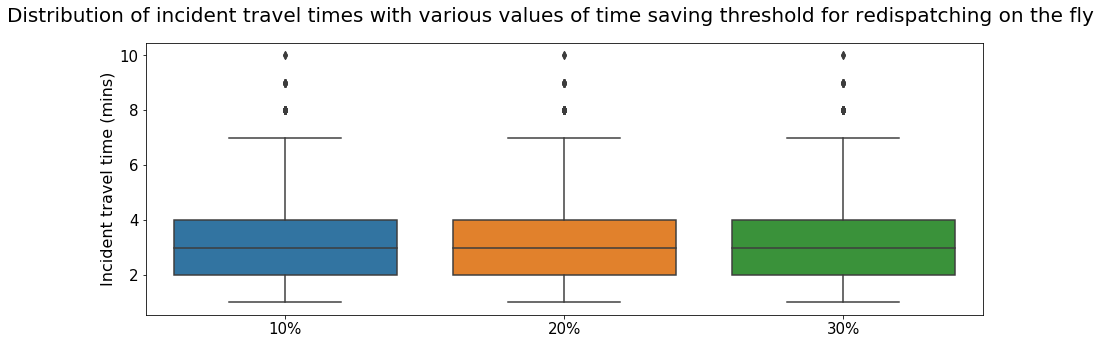

In [95]:

# plot the boxplot 
f, ax = plt.subplots(1, figsize=(15, 5))

## DISPATCH

ax = sns.boxplot(data=df3, ax = ax)


#f.suptitle('Distribution of incident travel times with various values of time saving threshold for redispatching on the fly', fontsize=20)


ax.set_xticklabels(ax.get_xticklabels(),rotation=0,  fontsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.set(xlabel=None)


ax.set_ylabel('Incident travel time (mins)', fontsize = 16)





#plt.savefig('../Images/SA_timeSaving.png', bbox_inches = 'tight')


plt.show()

In [85]:
df2.Travel_time_10.describe()

count    4789.000000
mean        2.903947
std         1.527923
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Travel_time_10, dtype: float64

In [86]:
df2.Travel_time_20.describe()

count    4789.000000
mean        2.904155
std         1.528414
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Travel_time_20, dtype: float64

In [96]:
df2.Travel_time_30.describe()

count    4789.000000
mean        2.905617
std         1.529120
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Travel_time_30, dtype: float64

## Travel speed (agents)

In [10]:
with open('results_SA_travelSpeed_scenario1.pkl', 'rb') as f:
    df_travel_speed_percent= pickle.load(f)
#dict_time_saving_percent
df_travel_speed_percent

,travel_speed_percent,num_agents,avg_response_time,percent_failed,deterrence
0,-30,10,10.888889,2.857143,0
1,-30,20,7.633333,2.857143,0
2,-30,30,6.114286,2.857143,0
3,-30,40,7.085714,2.857143,0
4,-30,50,7.571429,2.857143,0
...,...,...,...,...,...
4195,30,20,8.861111,8.510638,0
4196,30,30,4.142857,0.000000,0
4197,30,40,4.195652,2.127660,0
4198,30,50,3.191489,0.000000,0


In [ ]:
# Initialise the dataframe 
df2 = pd.DataFrame()
list_travel_speed_percent = [10,20,-10,-20]

for travel_speed_percent in list_travel_speed_percent:

    if len(df2) == 0:
        df2 = dict_travel_speed_percent[travel_speed_percent].copy()

    incidents = dict_travel_speed_percent[travel_speed_percent]
    # get the new incidents if any
    common = incidents.merge(df2,on=['Index'])
    new_incidents = incidents[(~incidents.Index.isin(common.Index))]
    # add new incidents to df2
    df2 = pd.concat([df2, new_incidents])

    df2['Dispatch_time_{}'.format(time_saving_percent)] = dict_travel_speed_percent[travel_speed_percent]['Dispatch_time']
    df2['Travel_time_{}'.format(time_saving_percent)] = dict_travel_speed_percent[travel_speed_percent]['Travel_time']

df2

In [ ]:
filter_col = ["Travel_time_10", 'Travel_time_20', 'Travel_time_-10', 'Travel_time_-20']
df3 = df2[filter_col]
df3.columns = ['+10%', '+20%', '-10%', '-20%',]
df3

In [ ]:

# plot the boxplot 
f, ax = plt.subplots(1, figsize=(15, 5))

## DISPATCH

ax = sns.boxplot(data=df3, ax = ax)


#f.suptitle('Distribution of incident travel times with various values of time saving threshold for redispatching on the fly', fontsize=20)


ax.set_xticklabels(ax.get_xticklabels(),rotation=0,  fontsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.set(xlabel=None)


ax.set_ylabel('Incident travel time (mins)', fontsize = 16)





#plt.savefig('../Images/SA_travelSpeed.png', bbox_inches = 'tight')


plt.show()